In [0]:
### Setup data split and transfer classifer environment

import numpy as np
import warnings
warnings.filterwarnings("ignore") # Suppressing Tensorflow 2.0 Warnings

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels
  
class pkg:
  def get_metadata(metadata_path, which_splits = ['train', 'test']):  
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: train vs test designation for the data entry
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]
    
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])
    
    metadata = pd.concat( [metadata_train, metadata_test] )
    
    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True 
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])
    
    metadata = pd.concat( [metadata_train, metadata_test] )
    
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)
  
class helpers:

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):

    # Create a line plot based to indicate the epoch at which the model had the highest accuracy
    
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.01, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)') 
    plt.show()

class models:
  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16, 
              }

    expert_conv = expert_dict[name](weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable
      
    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'], 
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95), 
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16, ResNet50
from imgaug import augmenters 

# defining project variables
# file variables
image_data_url       = 'https://drive.google.com/uc?id=1qmTuUyn0525-612yS-wkp8gHB72Wv_XP'
metadata_url         = 'https://drive.google.com/uc?id=1OfKnq3uIT29sXjWSZqOOpceig8Ul24OW' # Inspirit AI database on drivers in cars
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 4
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'

#
gdown.download(image_data_url, image_data_path , True)
gdown.download(metadata_url, metadata_path , True)


# pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])


# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_acc       = lambda history: helpers.plot_acc(history)

TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)  # Best Model saved

The data is summarised into even categories as follows
            class  count
0       Attentive   1911
1  DrinkingCoffee   1911
2     UsingMirror   1911
3      UsingRadio   1911
The following catplot shows that the dataframe is trimmed to have equal examples of each type


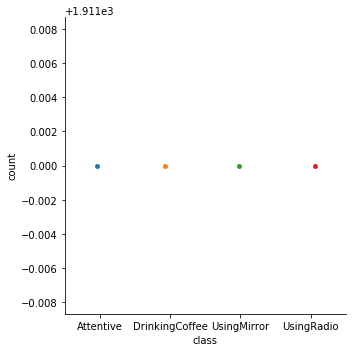

In [2]:
### Showcase of trimmed data

import seaborn as sns

count_types = _metadata.groupby(['class']).size()
plot_data = count_types.to_frame(name = 'count').reset_index()
print("The data is summarised into even categories as follows")
print(plot_data)

print("The following catplot shows that the dataframe is trimmed to have equal examples of each type")
sns.catplot(x= "class", y= "count", data = plot_data)



In [0]:
# Importing some tools to build the model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [0]:
# Setting train and test variables 

train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

train_data = train_data.reshape([-1, 64, 64, 3])
test_data = test_data.reshape([-1, 64, 64, 3])

train_labels = label_to_numpy(train_labels)
test_labels = label_to_numpy(test_labels)

In [0]:
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))
model = Sequential()

model.add(vgg_expert)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(lr=1e-3, momentum=0.95),
                metrics=['accuracy'])

In [6]:
# Model is trained and the accuracy history is stored. Best model is reatined through ModelCheckpoint
train_acc = model.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6724 samples, validate on 920 samples
Epoch 1/50
6724/6724 [==============================] - 17s 3ms/step - loss: 0.3954 - acc: 0.8452 - val_loss: 0.4838 - val_acc: 0.8163
Epoch 2/50
6724/6724 [==============================] - 13s 2ms/step - loss: 0.0623 - acc: 0.9850 - val_loss: 0.5362 - val_acc: 0.8239
Epoch 3/50
6724/6724 [==============================] - 13s 2ms/step - loss: 0.0493 - acc: 0.9862 - val_loss: 1.0591 - val_acc: 0.7728
Epoch 4/50
6724/6724 [==============================] - 12s 2ms/step - loss: 0.0199 - acc: 0.9954 - val_loss: 1.3294 - val_acc: 0.7043
Epoch 5/50
6724/6724 [==============================] - 12s 2ms/step - loss: 0.0348 - acc: 0.9902 - val_loss: 1.1978 - val_acc: 0.8283
Epoch 6/50
6724/6724 [==============================] - 12s 2ms/step - loss: 0.0162 - acc: 0.9955 - val_loss: 0.6744 - val_acc: 0.8533
Epoch 7/50
6724/6724 [=========================

In [0]:
# Setting up Salience Map dependencies

%%capture
# Hiding output for cleanliness
! pwd
! pip3 install scipy==1.1.0
! pip install git+https://github.com/raghakot/keras-vis.git -U
from vis.visualization import visualize_saliency, visualize_cam

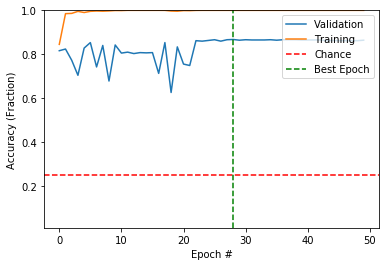

In [8]:
# Simple Line Plot for Epoch Accuracy
plot_acc(train_acc)

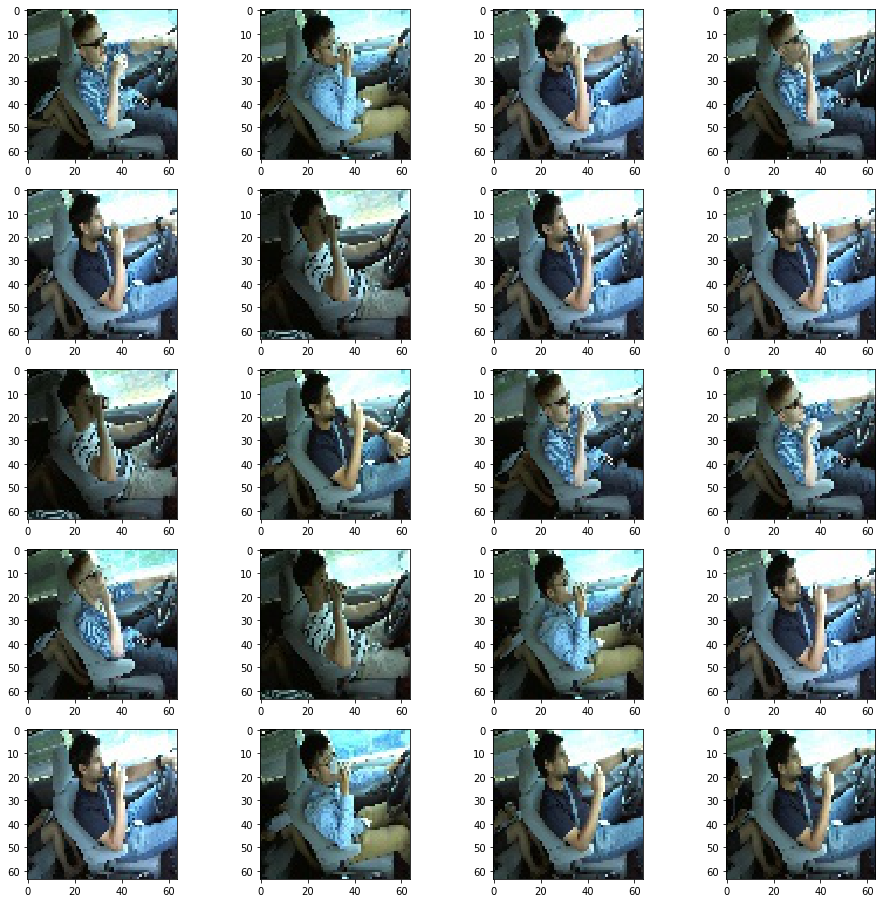

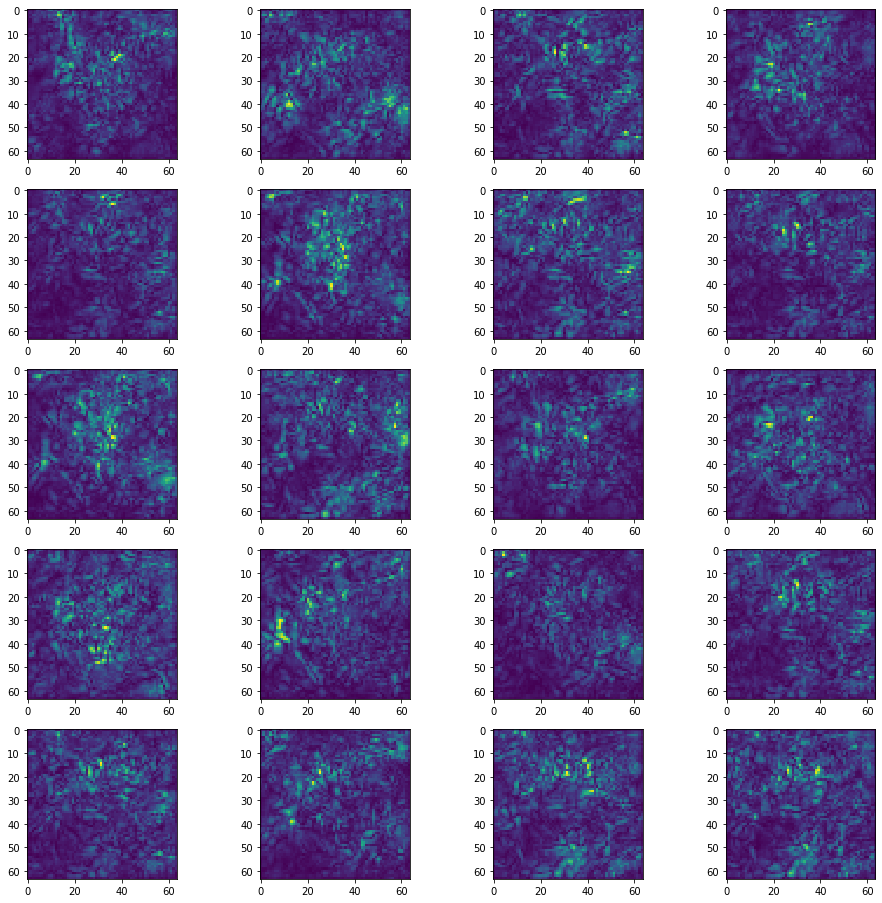

In [9]:
# Saliency Maps to Visualise Model

import random as rd

# define random image set to use
img_lst=set()
i = 0
while i < 21:
  img_no = rd.randrange(1,5000)
  if img_no not in img_lst:   # ensures we always end u with 20 images 
    i+=1
  img_lst.add(img_no)
  
def plot_grid(salient = False, my_data = test_data):
  fig=plt.figure(figsize=(16, 16))
  columns, rows = 4,5
  for i in range(1, columns*rows +1):
      img = my_data[i]
      if salient:
        img = visualize_saliency(model, 1, filter_indices = None, seed_input=img)
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()

# Random Image assortment of the original image and the saliency of the same image
plot_grid()
plot_grid(True)

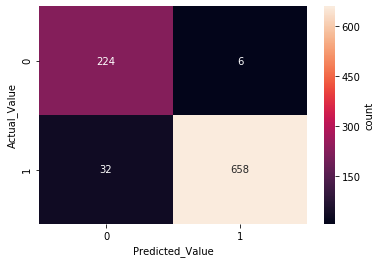

In [10]:
# Confusion Matrix to Test Accuracy

from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = model.predict(test_data)

y_known_binary = []
# Making known data binary
for label in test_labels:
  if label.argmax() == 0: # is Attentive:
    y_known_binary.append(0)
  else:
    y_known_binary.append(1)

y_pred_binary = []
# Making predicted data binary
for label in y_pred:
  if label.argmax() == 0: # is Attentive:
    y_pred_binary.append(0)
  else:
    y_pred_binary.append(1)

# Confusion Matrix to show a heat map of data accuracy
confusion = confusion_matrix(y_known_binary, y_pred_binary)
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual_Value');
plt.xlabel('Predicted_Value');